# **Import the libraries**

In [84]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

# **Loading the Data**

In [85]:
# Function tải và in hình dạng của hình ảnh
def print_image_shapes(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            print("Image shape:", img.shape)
        else:
            print("Error: Unable to load image at path:", img_path)

In [86]:
# Thư mục train, test, validation data
train_directory = "Train"
test_directory = "Test"
validation_directory = "Validation"


In [87]:
# Convert images to arrays without resizing
def load_image_as_array(image_path):
    with Image.open(image_path) as img:
        img_array = np.array(img)
        return img_array

In [88]:
# Tải train data
train_filepath = []
train_label = []

folds_train = os.listdir(train_directory)

for fold in folds_train:
    f_path = os.path.join(train_directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        train_filepath.append(img_path)
        train_label.append(fold)

In [89]:
train_file_path_series = pd.Series(train_filepath, name='filepath')
train_label_path_series = pd.Series(train_label, name='label')
df_train = pd.concat([train_file_path_series, train_label_path_series], axis=1)


In [90]:
# Load test data
test_filepath = []
test_label = []

folds_test = os.listdir(test_directory)

for fold in folds_test:
    f_path = os.path.join(test_directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        test_filepath.append(img_path)
        test_label.append(fold)


In [91]:
# Concatenate data paths with labels for test data
test_file_path_series = pd.Series(test_filepath, name='filepath')
test_label_path_series = pd.Series(test_label, name='label')
df_test = pd.concat([test_file_path_series, test_label_path_series], axis=1)


In [92]:
# Load validation data
validation_filepath = []
validation_label = []

folds_validation = os.listdir(validation_directory)

for fold in folds_validation:
    f_path = os.path.join(validation_directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        validation_filepath.append(img_path)
        validation_label.append(fold)


In [93]:
# Concatenate data paths with labels for validation data
validation_file_path_series = pd.Series(validation_filepath, name='filepath')
validation_label_path_series = pd.Series(validation_label, name='label')
df_validation = pd.concat([validation_file_path_series, validation_label_path_series], axis=1)

# **Preprocessing the Data**

In [94]:
# Define rescaling layer
rescale = layers.Rescaling(1./255)

# Load train dataset with rescaling
train_ds = keras.utils.image_dataset_from_directory(
    directory='Train',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))  # Apply rescaling

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [95]:
# Load validation dataset with rescaling
validation_ds = keras.utils.image_dataset_from_directory(
    directory='Validation',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))  

Found 800 files belonging to 2 classes.
Using 160 files for validation.


In [96]:
# Apply rescaling

# Load test dataset with rescaling
test_ds = keras.utils.image_dataset_from_directory(
    directory='Test',
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))  # Apply rescaling

Found 992 files belonging to 2 classes.


# **Visualizing Train Images**

In [97]:
# Directory paths for images with mask and without mask
with_mask_path = "Train/WithMask"
without_mask_path = "Train/WithoutMask"

In [98]:
# Function to sample images from a directory
def sample_images(directory, num_samples):
    images = [os.path.join(directory, file) for file in os.listdir(directory)]
    return random.sample(images, min(num_samples, len(images)))


In [99]:
# Sample images from each category
with_mask_img_paths = sample_images(with_mask_path, 8)
without_mask_img_paths = sample_images(without_mask_path, 8)


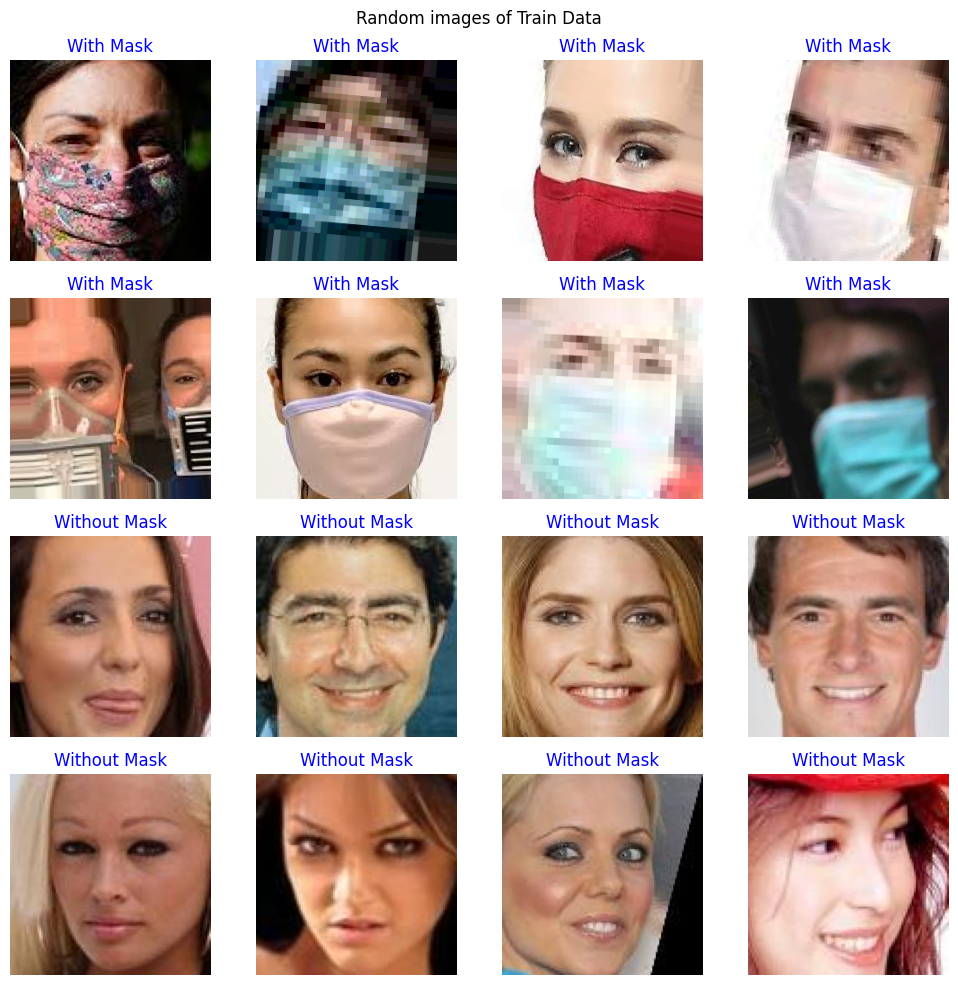

In [100]:
# Load and display images in subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through images with mask
for i, img_path in enumerate(with_mask_img_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title("With Mask",color= 'blue')
    axes[i//4, i%4].axis('off')

# Loop through images without mask
for i, img_path in enumerate(without_mask_img_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    axes[2+i//4, i%4].imshow(img)
    axes[2+i//4, i%4].set_title("Without Mask",color='blue')
    axes[2+i//4, i%4].axis('off')

plt.suptitle('Random images of Train Data')
plt.tight_layout()
plt.show()

# **Count of Train Label**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19932\1850045341.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


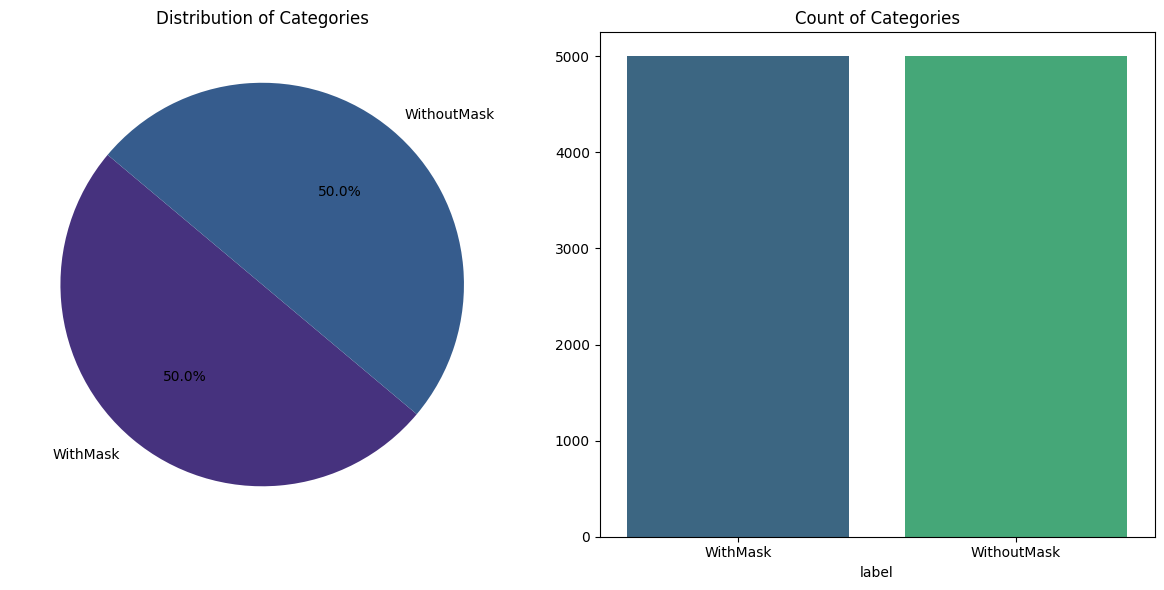

In [101]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Count of Test Label**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19932\852637156.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


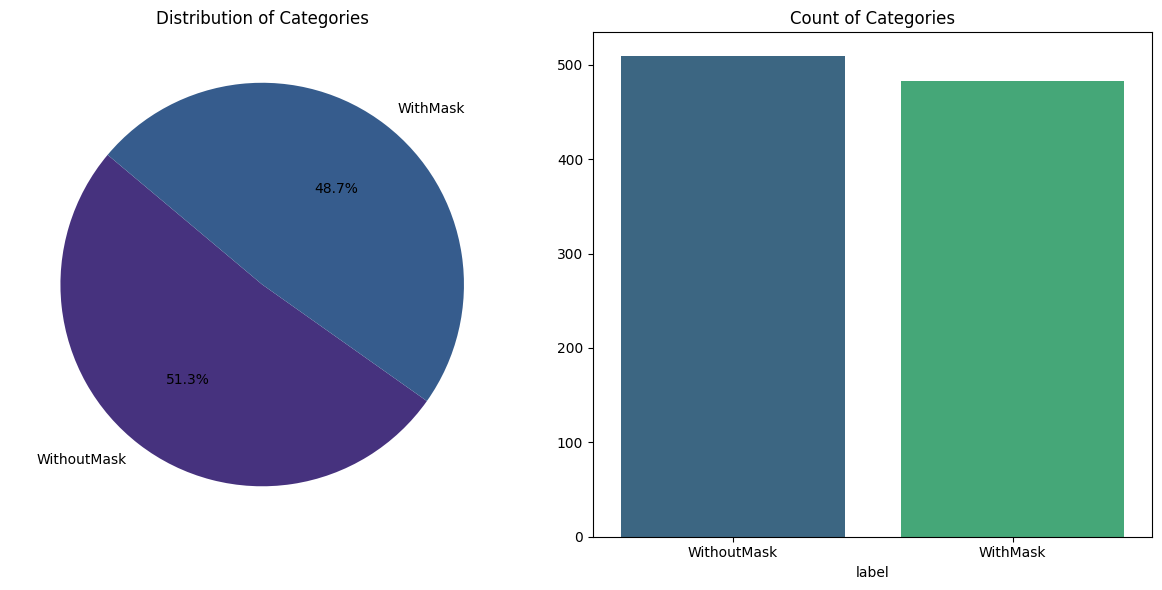

In [102]:
# Count the occurrences of each category in the 'category' column
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Build the Model**

In [103]:
# Define input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Define model architecture
model = tf.keras.models.Sequential([
    input_layer,
    # Convolutional layer with 32 filters and 3x3 kernel size, using ReLU activation
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D(),
    # Convolutional layer with 32 filters and 3x3 kernel size, using ReLU activation
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D(),
    # Convolutional layer with 32 filters and 3x3 kernel size, using ReLU activation
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer
    tf.keras.layers.MaxPooling2D(),
    # Flatten layer to convert 2D data to 1D
    tf.keras.layers.Flatten(),
    # Dropout Layer
    tf.keras.layers.Dropout(0.5),
    # Output layer with 1 units (for 10 classes) and softmax activation
    tf.keras.layers.Dense(2, activation='softmax'),
])

# **Summary of Model**

In [104]:
# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │        43,266 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,658 (244.76 KB)

 Trainable params: 62,658 (244.76 KB)

 Non-trainable params: 0 (0.00 B)

# **Compile the Model**

In [105]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',

              metrics=['accuracy'])

# **Fit the Model**

In [106]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=11,
                    callbacks=[early_stopping])

Epoch 1/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 233ms/step - accuracy: 0.8782 - loss: 0.2611 - val_accuracy: 0.9688 - val_loss: 0.0760
Epoch 2/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.9739 - loss: 0.0754 - val_accuracy: 0.9875 - val_loss: 0.0470
Epoch 3/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.9837 - loss: 0.0462 - val_accuracy: 0.9812 - val_loss: 0.0340
Epoch 4/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.9896 - loss: 0.0290 - val_accuracy: 0.9937 - val_loss: 0.0167
Epoch 5/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.9852 - loss: 0.0405 - val_accuracy: 0.9625 - val_loss: 0.1417
Epoch 6/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.9851 - loss: 0.0411 - val_accuracy: 0.9875 - val_loss: 0.0270
Epoch 7/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 225ms/step - accuracy: 0.9911 - loss: 0.0209 - val_accuracy: 0.9937 - val_loss: 0.0161
Epoch 8/11
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.9916 - loss: 0

# **Evaluate the Model**

In [107]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds) 

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9765 - loss: 0.0865
Test Loss: 0.052153389900922775
Test Accuracy: 0.9879032373428345


# **History Plot**

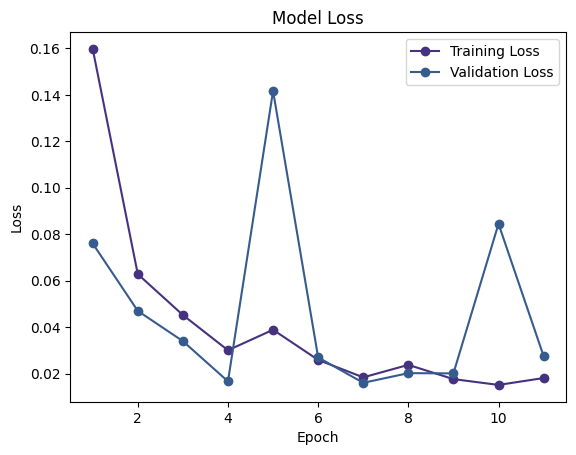

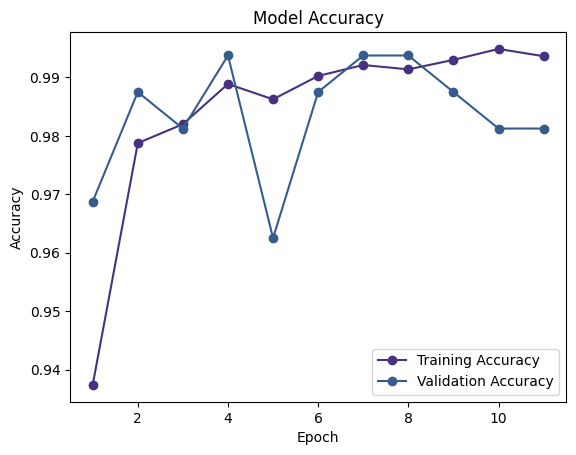

In [108]:
import matplotlib.pyplot as plt

# Define epochs
epochs = range(1, len(history.history['loss']) + 1)

# Plot training & validation loss
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Save model**


In [109]:
# Save the entire model (architecture, weights, and optimizer state)
model.save('my_model.h5')

# **Test with new data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


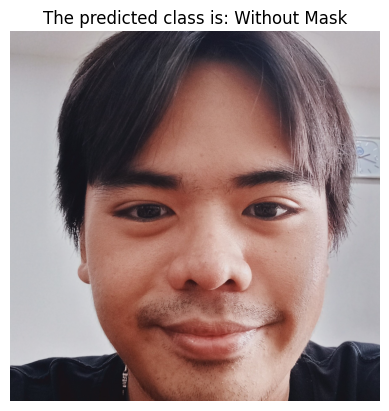

In [117]:
# Load the image
image_path = r'Test_with_real_data/z5672327947329_9df244e3d1c63b1d0374e4d97e016b15.jpg'
image = Image.open(image_path)

# Resize the image to match the input shape of the model
image_resized = image.resize((224, 224))

# Convert the image to a numpy array
image_array = np.array(image_resized)

# Ensure the image has 3 channels (in case it is grayscale or has alpha channel)
if image_array.shape[-1] != 3:
    image_array = np.stack((image_array,)*3, axis=-1)

# Normalize the image array
image_array_normalized = image_array / 255.0

# Add a batch dimension to the image array
image_array_normalized = np.expand_dims(image_array_normalized, axis=0)

# Make a prediction with the model
predictions = model.predict(image_array_normalized)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Define class labels (adjust this to match your dataset's classes)
class_labels = ['With Mask', 'Without Mask']  # replace with your actual class labels

# Plot the image and prediction
plt.imshow(image)
plt.title(f'The predicted class is: {class_labels[predicted_class[0]]}')
plt.axis('off')
plt.show()